# Data preparation
Download data from google drive

In [1]:
!pip install git+https://github.com/giuliano-oliveira/gdown_folder.git

  Cloning https://github.com/giuliano-oliveira/gdown_folder.git to /tmp/pip-req-build-euahf39w
  Running command git clone -q https://github.com/giuliano-oliveira/gdown_folder.git /tmp/pip-req-build-euahf39w
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=12125 sha256=4d56e4f5ad41589a24891fe9db8b8b652dcf372e61b36f5a44404dda892a3989
  Stored in directory: /tmp/pip-ephem-wheel-cache-tlnz3acy/wheels/da/5e/24/24fbdc00f3e6e91cefe494b31d53de8b91241ef924a15358dc
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4


In [2]:
!mkdir data

In [3]:
import gdown
id = '1eY0JuzNRJXTbF5Fhfqt5baPrIaEM3MxF'
url = f'https://drive.google.com/drive/folders/{id}'
print(url)
gdown.download_folder(url)

https://drive.google.com/drive/folders/1eY0JuzNRJXTbF5Fhfqt5baPrIaEM3MxF
Retrieving folder list
Processing file 1YEwet8I2yAP2CY9rZ1Tc4AX0Z08np5rU cases_data.json
Processing file 1_uMrd87sgOleu1S64blWKj60ngo_vNhi vax_data.json
Retrieving folder list completed
Building directory structure
Building directory structure completed


Downloading...
From: https://drive.google.com/uc?id=1YEwet8I2yAP2CY9rZ1Tc4AX0Z08np5rU
To: /content/data/cases_data.json
100%|██████████| 9.27M/9.27M [00:00<00:00, 112MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_uMrd87sgOleu1S64blWKj60ngo_vNhi
To: /content/data/vax_data.json
100%|██████████| 1.18M/1.18M [00:00<00:00, 118MB/s]

Download completed


'/content/data/vax_data.json'

In [4]:
#%cd data
%cd data

/content/data


Load data downloaded from drive into python

In [5]:
#get data
import json
with open('cases_data.json', encoding='utf8') as cases_file:
  cases_data = json.load(cases_file)
with open('vax_data.json', encoding='utf8') as vax_file:
  vax_data = json.load(vax_file)

Install prophet library to use model. Document of model can be found [here](https://facebook.github.io/prophet/).

In [7]:
#install modules
#Prophet: https://facebook.github.io/prophet/
!pip3 install pystan==2.19.1.1 prophet

     |████████████████████████████████| 65 kB 2.5 MB/s 
     |████████████████████████████████| 49 kB 5.3 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6638218 sha256=8b2dff914f530b8206680cec29c32cbeaab64a32de82a797eb48fd6ee9f3e9b5
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [8]:
import pandas as pd
from prophet import Prophet

The current `cases_data` and `vax_data `have 64 record correspond to 64 province of VietNam, since we only focused in number of infected and death cases in Ho Chi Minh city, we will filter it in to new dictionary named `hcm`. After that, we change the date format to pandas's convention and store new formatted data into `hcm_formatted`

In [11]:
def date_reformatting(date:str):
  splits = date.split(sep='/')
  if len(splits[1])==1: splits[1] = '0' + splits[1]
  if len(splits[0])==1: splits[0] = '0' + splits[0]
  return splits[2] + '-' + splits[1] + '-' + splits[0] 

keys = ['case_by_day', 'case_by_time', 'death_by_day', 'death_by_time']
hcm = { i: cases_data[1][i] for i in keys }

hcm_formatted = {}
for i in keys:
  sub_formatted = {}
  for j in hcm[i]:
    key = date_reformatting(j)
    dat = hcm[i][j]
    sub_formatted[key] = dat
  hcm_formatted[i] = sub_formatted

In [13]:
cap = {}
for i in hcm['case_by_day']:
  cap[i] = 8993082 - hcm['case_by_time'][i]
cap_f = {date_reformatting(i): cap[i] for i in cap}
cap_df = pd.DataFrame({'ds': cap_f})
cap_df = cap_df[:-1]
cap_df = cap_df.reset_index()

In [254]:
df = pd.DataFrame(hcm_formatted)
df = df[:-1]

In [303]:
dfc = pd.DataFrame({
    'ds': df.index,
    'y': df['case_by_time']
}).reset_index()

Examine the data, we see that the infected/death case by day data has a lot of outlier and is unreliable.

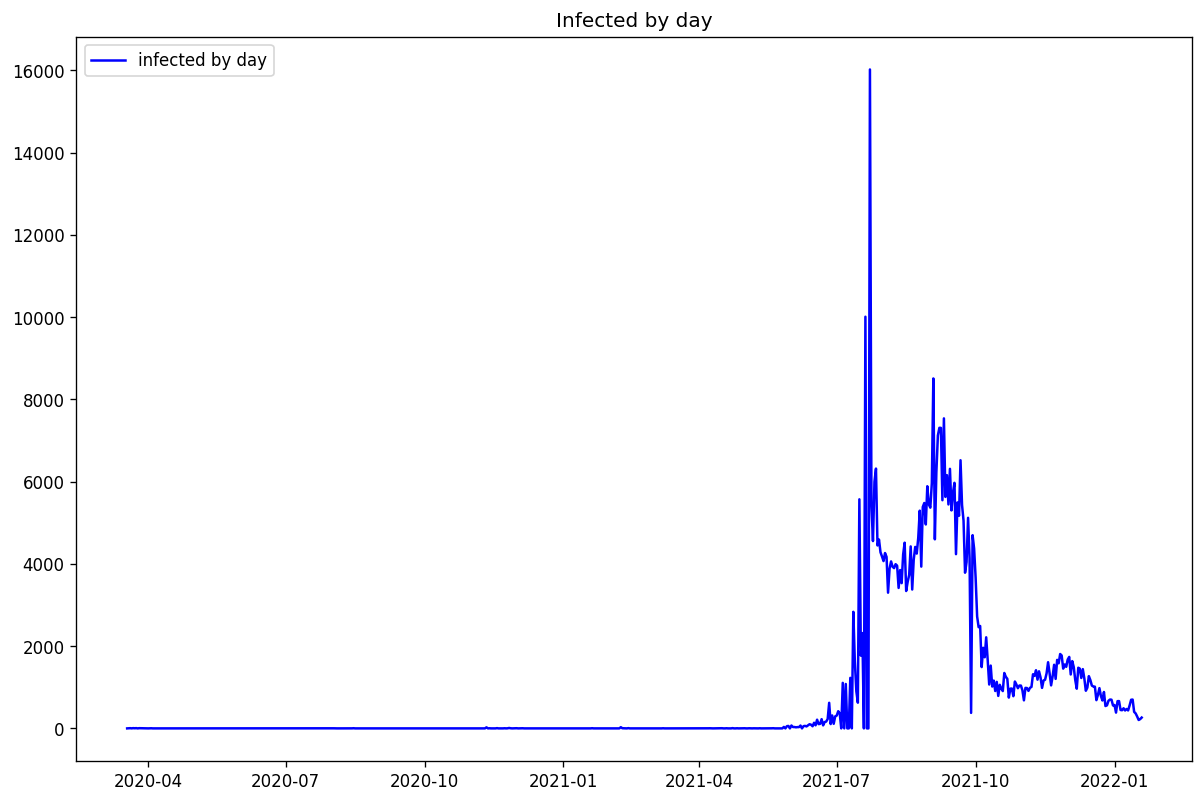

In [334]:
import matplotlib.pyplot as plt

df_case_day = pd.DataFrame({
    'ds': df.index,
    'y': df['case_by_day']
}).reset_index()

plt.figure(figsize=(12, 8), dpi=120)
plt.plot(pd.to_datetime(df_case_day['ds']), df_case_day['y'], 'b', label = 'infected by day')
plt.legend(loc = 'upper left')
plt.title('Infected by day')
plt.savefig('case_by_day.png')

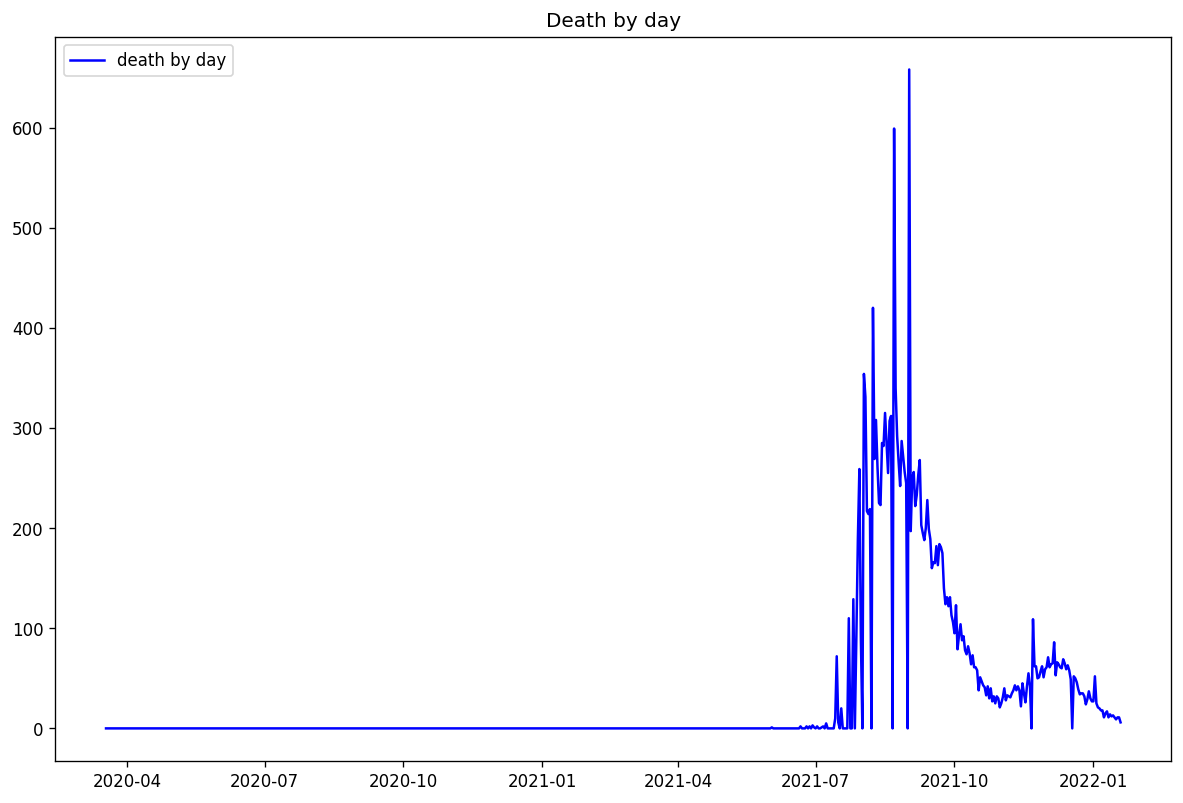

In [333]:
import matplotlib.pyplot as plt

df_death_day = pd.DataFrame({
    'ds': df.index,
    'y': df['death_by_day']
}).reset_index()

plt.figure(figsize=(12, 8), dpi=120)
plt.plot(pd.to_datetime(df_death_day['ds']), df_death_day['y'], 'b', label = 'death by day')
plt.legend(loc = 'upper left')
plt.title('Death by day')
plt.savefig('death_by_day.png')

# Experiment1: full data from 18-03-2020 to 20-01-2022

In [304]:
import numpy as np

In [305]:
cases_df = pd.DataFrame({
    'ds': df.index,
    'y': dfc['y'],
    'cap': cap_df['ds']
})

data_case_size = len(cases_df)
test_case_size = data_case_size // 10

cases_df_train = cases_df[:-test_case_size]
cases_df_test = cases_df[-test_case_size:]

In [306]:
last_day_cap = np.array(dfcp['cap'])[-1]
last_day_cap

8479675

Read [wiki](https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Vietnam) and list significant date in covid timeline.

In [307]:
changepoints = ['2020-05-01', '2020-07-28', '2021-01-28', '2021-03-07', '2021-04-20', '2021-07-26', '2021-10-01']

In [308]:
m = Prophet(yearly_seasonality=False, daily_seasonality=False, growth='logistic', changepoints=changepoints)
m.fit(cases_df_train)

`cases_future`: list of date to be predict

`history_cap`: maximum infected capacity of Hochiminh city

`cases_future_cap`: maximum infected capacity of Hochiminh city in the future (equal last day capacity of `history_cap`)



In [309]:
cases_future = m.make_future_dataframe(periods=120, include_history=False)
history_cap = cases_df_train[['ds', 'cap']]
cases_future_cap = pd.DataFrame({
    'ds': cases_future["ds"],
    'cap': last_day_cap
})
all_cap = pd.concat((history_cap, cases_future_cap))

Forecast next 120 day start from last train day

In [310]:
cases_forecast = m.predict(all_cap)
cases_forecast[['trend', 'yhat', 'yhat_lower', 'yhat_upper']]

,trend,yhat,yhat_lower,yhat_upper
0,0.154445,-19.349715,-16708.839777,17259.459215
1,0.158613,-141.762711,-16855.132318,17398.671576
2,0.162894,13.725368,-16721.550422,16307.775973
3,0.167291,18.416364,-16701.374673,17091.622688
4,0.171806,26.786468,-16672.146604,17688.694476
...,...,...,...,...
694,534125.971283,534144.220356,372216.930659,731723.433746
695,535003.841359,535030.456021,369177.095484,742795.984018
696,535883.056959,535913.849663,373543.229747,751994.297401
697,536763.619826,536835.826397,363161.421288,745255.924299


## Plotting the result

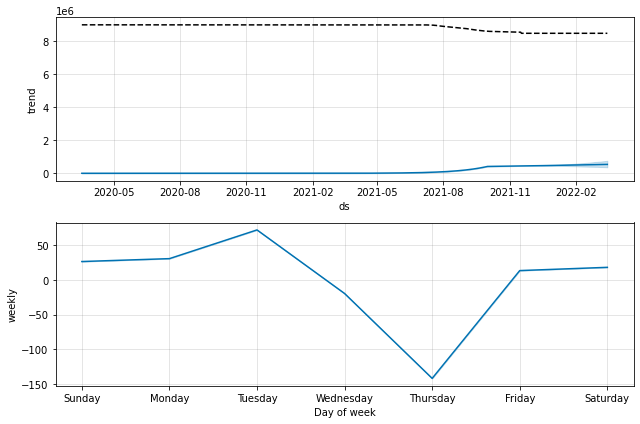

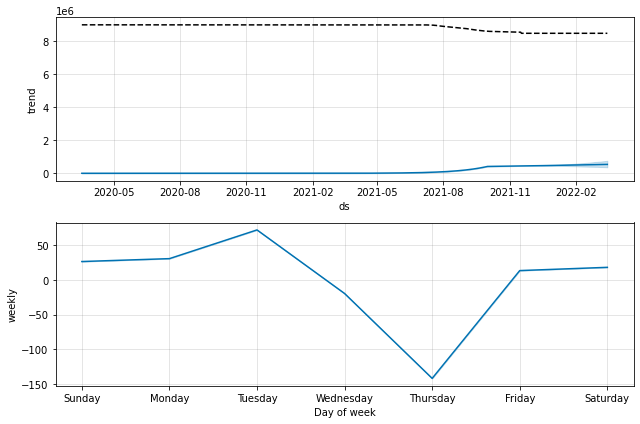

In [311]:
m.plot_components(cases_forecast)

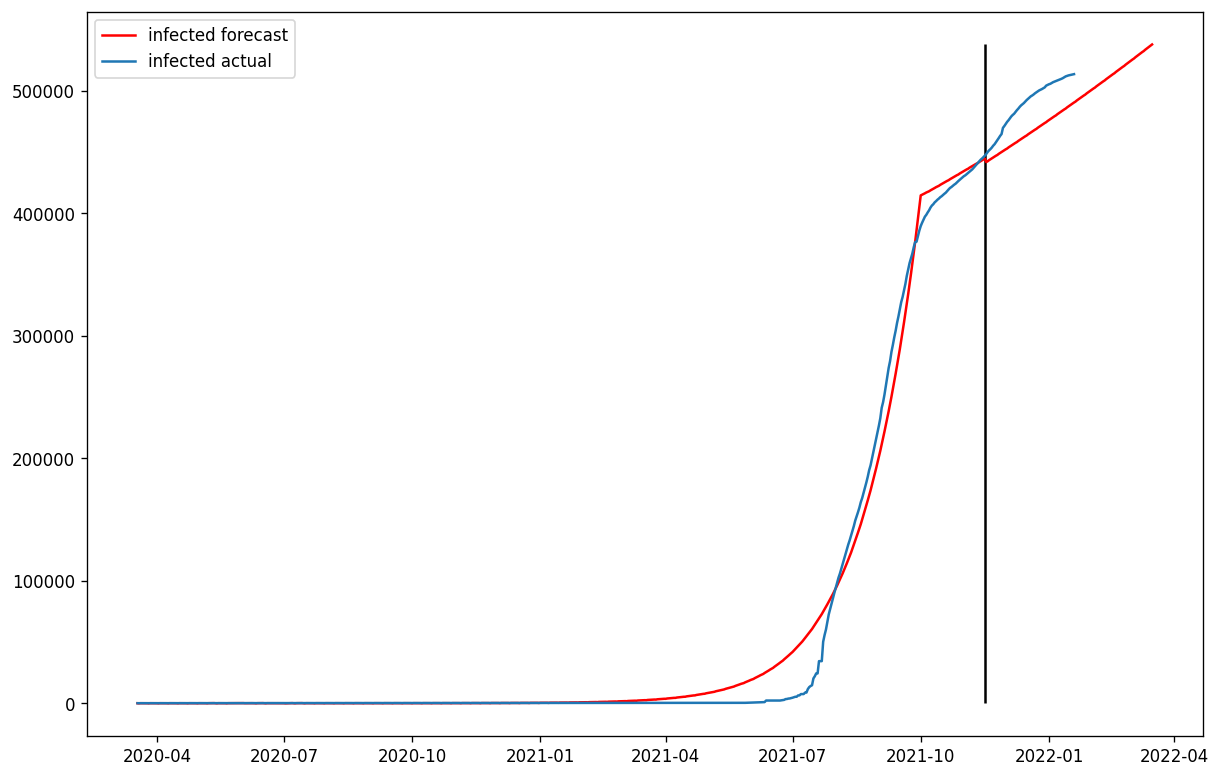

In [312]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8), dpi=120)
plt.plot(cases_forecast['ds'], cases_forecast['yhat'], 'r', label = 'infected forecast')
plt.plot(pd.to_datetime(cases_df['ds']), cases_df['y'], label = 'infected actual')
split_point = cases_df_train.iloc[-1]
plt.vlines(pd.to_datetime(split_point['ds']), ymin = 0, ymax = cases_forecast.iloc[-1]['yhat'])
plt.legend(loc='upper left')
plt.savefig('cases.png')

Compute MSE and R-square of predicted infected cases

In [313]:
from sklearn.metrics import mean_squared_error, r2_score
first_test_date = pd.to_datetime(cases_df_test.iloc[0]['ds'])
last_test_date = pd.to_datetime(cases_df_test.iloc[-1]['ds'])
print(first_test_date, last_test_date)
cases_forecast2 = cases_forecast[(cases_forecast['ds'] >= first_test_date) & (cases_forecast['ds'] <= last_test_date)]
MSE_cases_test = mean_squared_error(cases_df_test['y'].to_numpy(), cases_forecast2['yhat'].to_numpy())
r2_cases_test = r2_score(cases_df_test['y'].to_numpy(), cases_forecast2['yhat'].to_numpy())
print(MSE_cases_test, r2_cases_test)

2021-11-17 00:00:00 2022-01-19 00:00:00
608116810.2397506 -0.5486720823172304


# Experiment 2: forecast death by time

In this experiment we will try to forecast cummulative death case in Hochiminh city

In [319]:
death_df = pd.DataFrame({
    'ds': hcm_formatted['death_by_time'].keys(),
    'y': hcm_formatted['death_by_time'].values(),
    'cap': hcm_formatted['case_by_time'].values()
}
)

data_size = len(death_df)
test_size = data_size // 10

death_df_train = death_df[:-test_size]
death_df_test = death_df[-test_size:]

In [320]:
dm = Prophet(growth='logistic')
dm.fit(death_df_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [321]:
death_future = dm.make_future_dataframe(periods=120, include_history=False)
death_future_cap = pd.merge(how='inner', left=death_future, right=cases_forecast[['ds', 'yhat']], on='ds')
death_future_cap.rename(columns={'yhat': 'cap'}, inplace=True)
docap = pd.concat((death_df_train[['ds', 'cap']], death_future_cap))

In [322]:
death_forecast = dm.predict(docap)
death_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          699 non-null    datetime64[ns]
 1   trend                       699 non-null    float64       
 2   cap                         699 non-null    float64       
 3   yhat_lower                  699 non-null    float64       
 4   yhat_upper                  699 non-null    float64       
 5   trend_lower                 699 non-null    float64       
 6   trend_upper                 699 non-null    float64       
 7   additive_terms              699 non-null    float64       
 8   additive_terms_lower        699 non-null    float64       
 9   additive_terms_upper        699 non-null    float64       
 10  weekly                      699 non-null    float64       
 11  weekly_lower                699 non-null    float64       

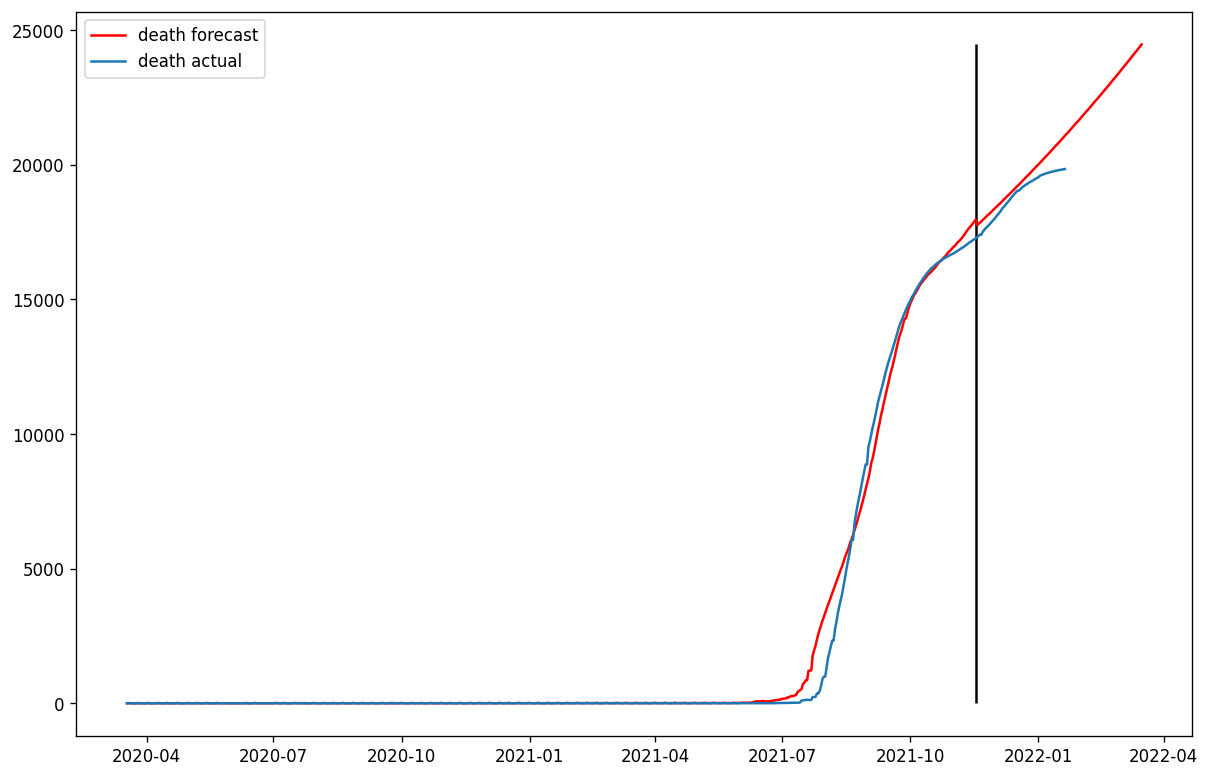

In [323]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8), dpi=120)
plt.plot(death_forecast['ds'], death_forecast['yhat'], 'r', label = 'death forecast')
plt.plot(pd.to_datetime(death_df['ds']), death_df['y'], label = 'death actual')
split_point = death_df_train.iloc[-1]
plt.vlines(pd.to_datetime(split_point['ds']), ymin = 0, ymax = death_forecast.iloc[-1]['yhat'])
plt.legend(loc='upper left')
plt.savefig('death.png')


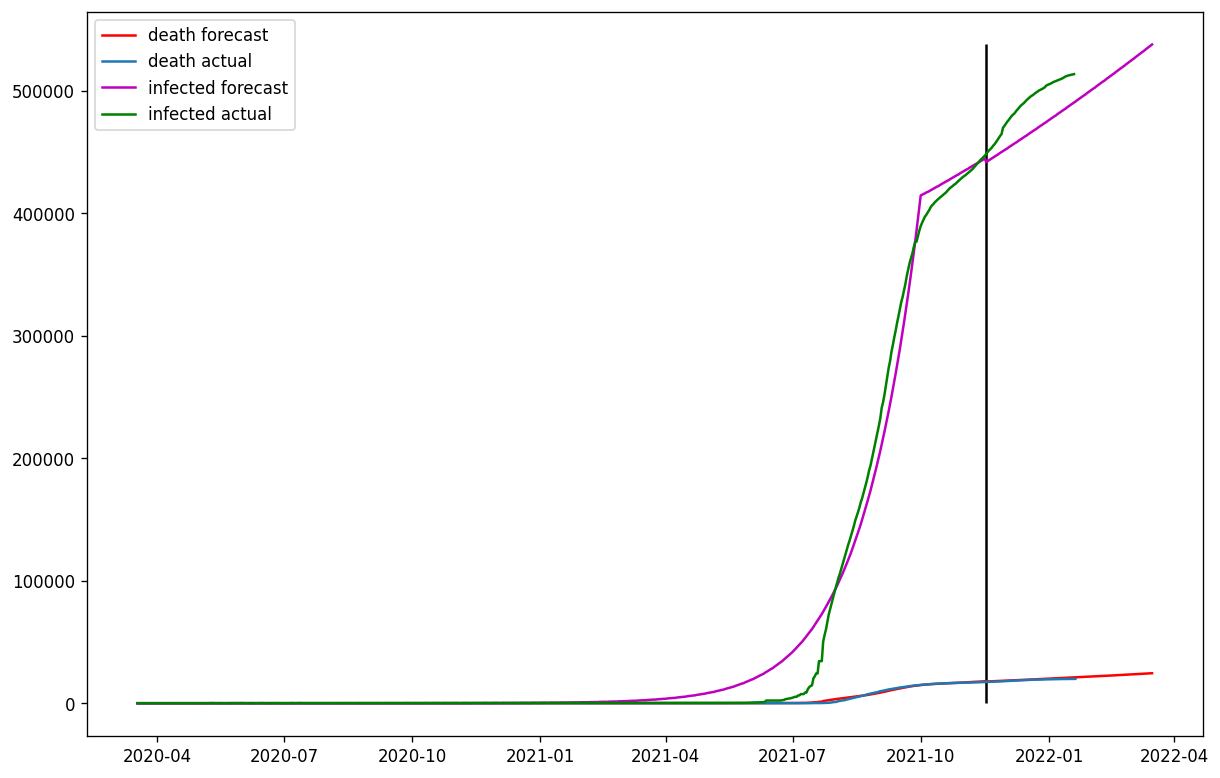

In [324]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8), dpi=120)
plt.plot(death_forecast['ds'], death_forecast['yhat'], 'r', label = 'death forecast')
plt.plot(pd.to_datetime(death_df['ds']), death_df['y'], label = 'death actual')
plt.plot(cases_forecast['ds'], cases_forecast['yhat'], 'm-', label = 'infected forecast')
plt.plot(pd.to_datetime(cases_df['ds']), cases_df['y'], 'g', label = 'infected actual')
split_point = death_df_train.iloc[-1]
plt.vlines(pd.to_datetime(split_point['ds']), ymin = 0, ymax = cases_forecast.iloc[-1]['yhat'])
plt.legend(loc='upper left')
plt.savefig('death_case.png')

Compute MSE and R-square of predicted death cases

In [325]:
from sklearn.metrics import mean_squared_error, r2_score
first_test_date = pd.to_datetime(death_df_test.iloc[0]['ds'])
last_test_date = pd.to_datetime(death_df_test.iloc[-1]['ds'])
print(first_test_date, last_test_date)
death_forecast2 = death_forecast[(death_forecast['ds'] >= first_test_date) & (death_forecast['ds'] <= last_test_date)]
MSE_death_test = mean_squared_error(death_df_test['y'].to_numpy(), death_forecast2['yhat'].to_numpy())
r2_death_test = r2_score(death_df_test['y'].to_numpy(), death_forecast2['yhat'].to_numpy())
print(MSE_death_test, r2_death_test)

2021-11-18 00:00:00 2022-01-20 00:00:00
303561.5378805531 0.5350095963965906
